In [33]:
from screenshot import screenshot
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np


In [34]:
def display(imArray, r=1, c=1, title=[], size=6, gray=True):
    fig, ax = plt.subplots(r, c, figsize=(size*c, size*r))
    # fig.patch.set_facecolor('#090909')
    if(len(imArray.shape) > 2):
        n = r*c
        ax = np.array(ax).flatten()
        if(len(title) != n):
            title = np.repeat("", n)
        for i in range(n):
            ax[i].axis('off')
            if(gray):
                ax[i].imshow(imArray[i], cmap='gray')
            else:
                ax[i].imshow(imArray[i])
            ax[i].set_title(str(title[i]))
    else:
        ax.axis('off')
        if(gray):
            ax.imshow(imArray, cmap='gray')
        else:
            ax.imshow(imArray)
        ax.set_title(str(title))


def concat(x, y):
    return np.array([np.array(x), np.array(y)])


def saveFromArray(array, name):
    frame = Image.fromarray(array)
    frame.save('assets/'+name + '.jpg')


def saveFromImage(img, name):
    img.save('assets/'+name + '.jpg')


h = 450
w = 800


In [35]:
# frame = Image.fromarray(screenshot())
# image = 'ligne.jpg'
# frame.save(image)


In [36]:
# frame = Image.fromarray(screenshot())
# image = 'virage.jpg'
# frame.save(image)


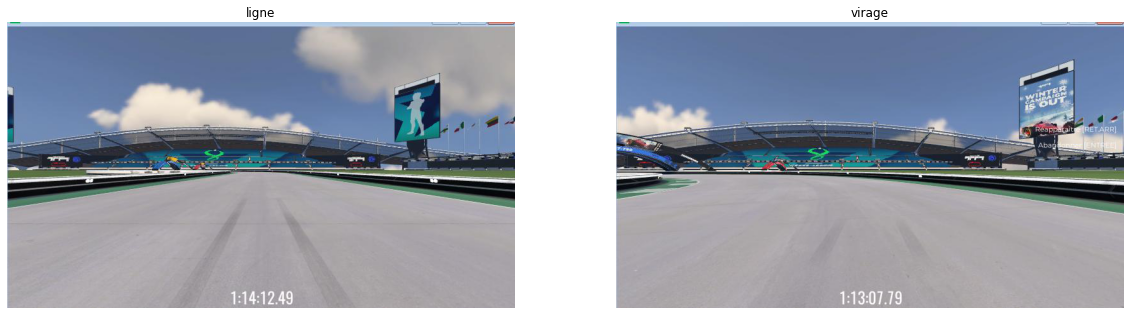

In [37]:
ligne = Image.open("assets/ligne.jpg")
virage = Image.open("assets/virage.jpg")

display(concat(ligne, virage), r=1, c=2, title=[
        'ligne', 'virage'], gray=False, size=10)


In [38]:
def initCrop(img, l, u, r, d):
    img = img.crop((l, u, img.size[0]-r, img.size[1]-d))
    return img


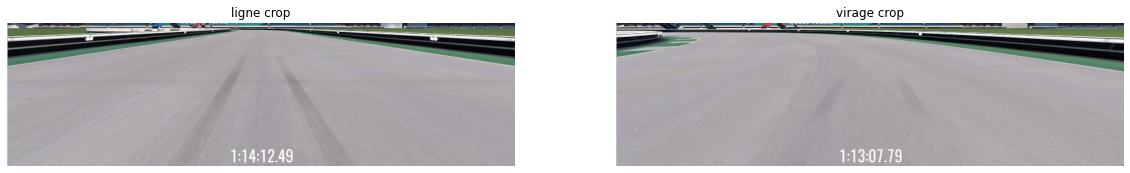

In [39]:
ligneCrop = initCrop(ligne, 0, ligne.size[1]//2, 0, 0)
virageCrop = initCrop(virage, 0, virage.size[1]//2, 0, 0)

saveFromImage(ligneCrop, "ligne_crop")
saveFromImage(virageCrop, "virage_crop")

display(concat(ligneCrop, virageCrop), r=1, c=2, title=[
        'ligne crop', 'virage crop'], gray=False, size=10)


In [40]:
def imgReshape(img):
    img = img.resize((w, h), Image.ANTIALIAS)
    img = img.convert('L')
    img = np.array(img)
    return img.reshape((h, w, 1))


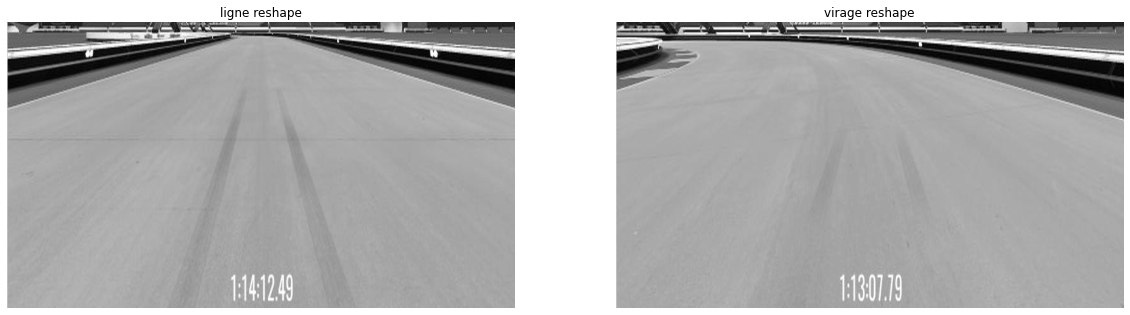

In [41]:
ligneReshape = imgReshape(ligneCrop)
virageReshape = imgReshape(virageCrop)

saveFromArray(np.squeeze(ligneReshape, axis=2), "ligne_reshape")
saveFromArray(np.squeeze(ligneReshape, axis=2), "virage_reshape")

display(concat(ligneReshape, virageReshape), r=1, c=2, title=[
        'ligne reshape', 'virage reshape'], gray=True, size=10)


In [42]:
def threshold(img, threshold=50):
    img = img.point(lambda p: p < threshold and 255)
    return img


In [43]:
ligneTreshold = threshold(Image.fromarray(np.squeeze(ligneReshape, axis=2)))
virageTreshold = threshold(Image.fromarray(np.squeeze(virageReshape, axis=2)))

saveFromImage(ligneTreshold, "ligne_threshold")
saveFromImage(virageTreshold, "virage_threshold")


In [44]:
def findWalls(img_np, no_lines=11, threshold=50):
    h, w, _ = img_np.shape
    dx = w//no_lines

    end_points = []
    start_points = range(dx//2, w, dx)
    for start_point in start_points:
        distance = h - 1
        while distance >= 0:
            if img_np[distance][start_point] <= threshold:  # pixel threshold
                break
            distance -= 1
        distance = h - distance - 1
        end_points.append(distance * 1.0 / h)

    return end_points


In [48]:
def drawLines(end_points, img):
    w = 800
    h = 450

    no_lines = len(end_points)
    dx = w//no_lines

    imgDraw = ImageDraw.Draw(img)

    start_points = range(dx//2, w, dx)
    for start_point, end_point in zip(start_points, end_points):
        # line = [(x1, y1), (start_point, end_point)]
        line = [(start_point,  h-(end_point*h)), (w//2, h)]
        imgDraw.line(line, fill="white", width=1)

    return img


def drawLines2(end_points, img):
    w = 800
    h = 450

    no_lines = len(end_points)
    dx = w//no_lines

    imgDraw = ImageDraw.Draw(img)

    start_points = range(dx//2, w, dx)
    for start_point, end_point in zip(start_points, end_points):
        # line = [(x1, y1), (start_point, end_point)]
        line = [(start_point,  h-(end_point*h//2)), (w//2, h)]
        imgDraw.line(line, fill="blue", width=1)

    return img


def drawCuts(end_points, img):
    w = 800
    h = 450

    no_lines = len(end_points)
    dx = w//no_lines

    imgDraw = ImageDraw.Draw(img)

    start_points = range(dx//2, w, dx)
    for start_point, end_point in zip(start_points, end_points):
        # line = [(x1, y1), (start_point, end_point)]
        line = [(start_point,  0), (start_point, h)]
        imgDraw.line(line, fill="white", width=1)

    return img


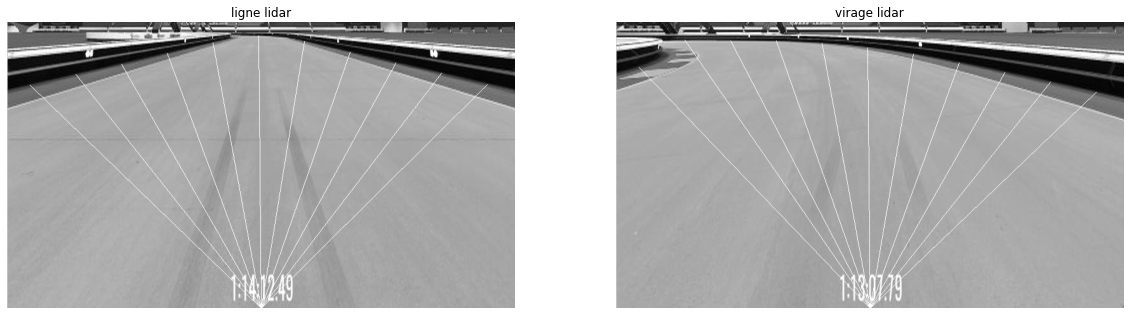

In [50]:
no = 11
lignePoints = findWalls(np.array(ligneReshape), no_lines=no)
viragePoints = findWalls(np.array(virageReshape), no_lines=no)

ligneCuts = drawCuts(lignePoints, Image.fromarray(
    np.squeeze(ligneReshape, axis=2)))
virageCuts = drawCuts(viragePoints, Image.fromarray(
    np.squeeze(virageReshape, axis=2)))

ligneLidar = drawLines(lignePoints, Image.fromarray(
    np.squeeze(ligneReshape, axis=2)))
virageLidar = drawLines(viragePoints, Image.fromarray(
    np.squeeze(virageReshape, axis=2)))

saveFromImage(ligneCuts, "ligne_cuts")
saveFromImage(virageCuts, "virage_cuts")

saveFromImage(ligneLidar, "ligne_lidar")
saveFromImage(virageLidar, "virage_lidar")

display(concat(ligneLidar, virageLidar), r=1, c=2, title=[
        'ligne lidar', 'virage lidar'], gray=True, size=10)


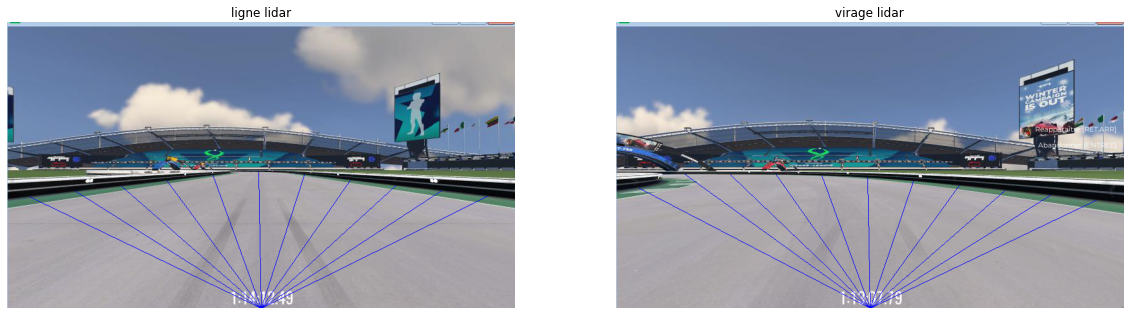

In [56]:
ligneLidar2 = drawLines2(lignePoints, ligne)
virageLidar2 = drawLines2(viragePoints, virage)

saveFromImage(ligneLidar2, "ligne_lidar2")
saveFromImage(virageLidar2, "virage_lidar2")

display(concat(ligneLidar2, virageLidar2), r=1, c=2, title=[
        'ligne lidar', 'virage lidar'], gray=True, size=10)